<a href="https://colab.research.google.com/github/ASHWINKUMAR1996/PokemonGenerator/blob/master/Cartoon_Generator_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import imutils
import cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, BatchNormalization, Input, Reshape, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from zipfile import ZipFile
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
# upzip the folder
with ZipFile("drive/MyDrive/Cartoon_Generator.zip", "r") as zip:
  zip.extractall()

In [ ]:
# upzip the folder
with ZipFile("drive/MyDrive/archive.zip", "r") as zip:
  zip.extractall()

In [ ]:
def convert_image_thumbnail(image, thumbnail_size=(200, 200)):
  background = Image.new('RGB', thumbnail_size, "black") 
  # print(background.size)   
  source_image = Image.open(f).convert("RGB")
  # print(source_image.size)   
  source_image.thumbnail(thumbnail_size)
  # print(source_image.size)   
  (w, h) = source_image.size
  background.paste(source_image, ((thumbnail_size[0] - w) // 2, (thumbnail_size[1] - h) // 2 ))

  background = img_to_array(background)

  return background

In [ ]:
# create a dataset from the images

images_folder = "cropped"
train_data = []

for file in os.listdir(images_folder):

    f = os.path.join(images_folder, file)
    # image = convert_image_thumbnail(f, (200, 200))
    image = cv2.imread(f)
    train_data.append(image)

train_data = np.array(train_data).astype("float32")
train_data = (train_data - 127.5) / 127.5
print(train_data.shape)

(9877, 200, 200, 3)


In [ ]:
# create a dataset from the images

images_folder = "Cartoon_Generator/images"
train_data = []
file_count = 500

for folder in os.listdir(images_folder):

  roi_folder = os.path.join(images_folder, folder, "roi")
  for file in os.listdir(roi_folder)[:file_count]:

    try:
      f = os.path.join(roi_folder, file)
      image = convert_image_thumbnail(f, (200, 200))
      train_data.append(image)
    
    except Exception as e:
      continue

train_data = np.array(train_data).astype("float32")
train_data = (train_data - 127.5) / 127.5
print(train_data.shape)

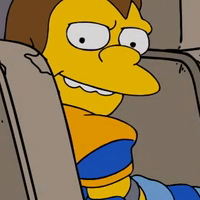

In [ ]:
cv2_imshow(train_data[2000] * 127.5 + 127.5)

In [ ]:
benchmark = np.random.uniform(-1, 1, (256, 100))
epochs = 200
batch_size = 64
INIT_LR = 1e-4
beta = 0.5

In [ ]:
class GAN:

  def __init__(self, height, width, dim=7, depth=64, channel=1, input=100, fc=512):

    self.dim = dim
    self.depth = depth
    self.channel = channel
    self.input = input
    self.fc = fc
    self.height = height
    self.width = width

  def build_generator(self):

    model = Sequential()

    # first set of layers
    model.add(Dense(self.fc, activation="relu", input_shape=(self.input, )))
    model.add(BatchNormalization())
    
    # second set of layers
    model.add(Dense(self.dim*self.dim*self.depth, activation="relu"))
    model.add(BatchNormalization())

    model.add(Reshape((self.dim, self.dim, self.depth)))

    # third set - convtranspose
    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization())

    # fourth set - convtranspose
    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization())

    # # fifth set - convtranspose
    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization())

    # sixth set - convtranspose
    model.add(Conv2DTranspose(filters=self.channel, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="tanh"))
    model.add(BatchNormalization())

    print(model.summary())
    return model

  def build_discriminator(self):

    model = Sequential()

    # first conv2d
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding="same", input_shape=(self.height, self.width, self.channel)))
    model.add(LeakyReLU(alpha=0.2))

    # second conv2d
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # third conv2d
    # model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding="same"))
    # model.add(LeakyReLU(alpha=0.2))

    # fourth conv2d
    # model.add(Conv2D(filters=512, kernel_size=(5, 5), strides=(2, 2), padding="same"))
    # model.add(LeakyReLU(alpha=0.2))

    # Flatten
    model.add(Flatten())
    model.add(Dense(units=self.fc))
    model.add(LeakyReLU(alpha=0.2))
    
    #sigmoid layer
    model.add(Dense(units=1, activation="sigmoid"))

    print(model.summary())
    return model

In [ ]:
# build discriminator model
disc = GAN(height=200, width=200, dim=25, depth=512, channel=3, input=100, fc=512).build_discriminator()
discOpt = Adam(lr=INIT_LR, beta_1=beta, decay=INIT_LR / epochs)
disc.compile(loss="binary_crossentropy", optimizer=discOpt)

# freeze trainable weights in discriminator
disc.trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               81920512  
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

In [ ]:
# build generator model and the complete gan model
# generator = GAN(28, 28, 7, 64, 1, 100, 512).build_generator()
generator = GAN(height=200, width=200, dim=25, depth=512, channel=3, input=100, fc=512).build_generator()
input = Input(shape=(100, ))
gan_model = Model(inputs=input, outputs=disc(generator(input)))
ganOpt = Adam(lr=INIT_LR, beta_1=beta, decay=INIT_LR / epochs)
gan_model.compile(loss="binary_crossentropy", optimizer=ganOpt)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               51712     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 320000)            164160000 
_________________________________________________________________
batch_normalization_1 (Batch (None, 320000)            1280000   
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 256)      

In [ ]:
gan_model.predict(benchmark[0:3])

array([[0.4999572 ],
       [0.49997652],
       [0.49995458]], dtype=float32)

In [ ]:
generator.predict(benchmark[0:2]).shape

(2, 200, 200, 3)

In [ ]:
batches = train_data.shape[0] // batch_size

for epoch in range(epochs):

  print("Epoch: {}/{}".format(epoch + 1, epochs))
  for i in range(batches):
    batch = train_data[i * batch_size : (i+1) * batch_size]

    # generate random noise images
    noise = np.random.uniform(-1, 1, (batch_size, 100))
    noise_image = generator.predict(noise, verbose=0)

    # print(batch.shape, noise_image.shape)
    temp_data = np.concatenate([batch, noise_image], axis=0)
    labels = np.array([1] * batch_size + [0] * batch_size)
    # print(temp_data.shape, labels.shape)
    temp_data, labels = shuffle(temp_data, labels)

    disc.train_on_batch(temp_data, labels)

    noise = np.random.uniform(-1, 1, (batch_size, 100))
    false_labels = np.array([1] * batch_size)
    gan_model.train_on_batch(noise, false_labels)

  if epoch % 5 == 0 and epoch != 0:
    output = generator.predict(benchmark)
    output = (output * 127.5 + 127.5).astype("uint8")

    output_slice = output[[20, 40, 60], :]

    for i in [20, 40, 60]:
      path = "/content/drive/MyDrive/{}_{}.jpg".format(epoch, str(i))
      cv2.imwrite(path, output[i])

Epoch: 1/200
Epoch: 2/200
Epoch: 3/200
Epoch: 4/200
Epoch: 5/200
Epoch: 6/200
Epoch: 7/200
Epoch: 8/200
Epoch: 9/200
Epoch: 10/200
Epoch: 11/200
Epoch: 12/200
Epoch: 13/200
Epoch: 14/200
Epoch: 15/200
Epoch: 16/200
Epoch: 17/200
Epoch: 18/200
Epoch: 19/200
Epoch: 20/200
Epoch: 21/200
Epoch: 22/200
Epoch: 23/200
Epoch: 24/200
Epoch: 25/200
Epoch: 26/200
Epoch: 27/200
Epoch: 28/200
Epoch: 29/200
Epoch: 30/200
Epoch: 31/200
Epoch: 32/200
Epoch: 33/200
Epoch: 34/200
Epoch: 35/200
Epoch: 36/200
Epoch: 37/200
Epoch: 38/200
Epoch: 39/200
Epoch: 40/200
Epoch: 41/200
Epoch: 42/200
Epoch: 43/200
Epoch: 44/200
Epoch: 45/200
Epoch: 46/200
Epoch: 47/200
Epoch: 48/200
Epoch: 49/200
Epoch: 50/200
Epoch: 51/200
Epoch: 52/200
Epoch: 53/200
Epoch: 54/200
Epoch: 55/200
Epoch: 56/200
Epoch: 57/200
Epoch: 58/200
Epoch: 59/200
Epoch: 60/200
Epoch: 61/200
Epoch: 62/200
Epoch: 63/200
Epoch: 64/200
Epoch: 65/200
Epoch: 66/200
Epoch: 67/200
Epoch: 68/200
Epoch: 69/200
Epoch: 70/200
Epoch: 71/200
Epoch: 72/200


In [ ]:
output = generator.predict(benchmark)
output = (output * 127.5 + 127.5).astype("uint8")

In [ ]:
output.shape

In [ ]:
cv2_imshow(output[255])

In [ ]:
output[70].shape

In [ ]:
i = np.squeeze(output[150], axis=2)
i = Image.fromarray(i)
plt.imshow(i, cmap="gray")

In [ ]:
path = "/content/drive/MyDrive/new.jpg"
cv2.imwrite(path, output[255])